In [23]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional,GRU
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf
import keras_tuner as kt

In [24]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [25]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [26]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [27]:
ticker='TSLA'

In [28]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [29]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [30]:
dates = pd.to_datetime(df['Date'])

In [31]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [32]:
df_for_training = df[cols].astype(float)

In [33]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [34]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [35]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [36]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [37]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [38]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [39]:
def build_model(hp):
    hp_units=hp.Int('units',min_value=2,max_value=240,step=2)
    model=Sequential()
    model.add(Bidirectional(GRU(hp_units,activation='relu',input_shape=(X.shape[1],X.shape[2]),return_sequences=False)))
    model.add(Dense(y.shape[1]))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')

    return model

early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [40]:

tuner = kt.GridSearch(build_model,
                     objective='val_loss',
                     project_name='bi_gru_tuning',
                     )

Reloading Tuner from ./bi_gru_tuning/tuner0.json


In [41]:
tuner.search(X, y, epochs=1000, validation_split=0.2, callbacks=[early_stop])

In [42]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 144.



In [43]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def forecast_bias(y_true, y_pred):
    return 100 * (np.mean(y_pred) - np.mean(y_true)) / np.mean(y_true)

Epoch 1/1000


2023-11-18 14:19:37.090404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 14:19:37.090465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 14:19:37.090482: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 14:19:37.090614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-18 14:19:37.090621: I tensorflow/core/co

3/3 [==============================] - 2s 116ms/step - loss: 0.0418 - val_loss: 0.1042
Epoch 2/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.0331 - val_loss: 0.0903
Epoch 3/1000
3/3 [==============================] - 0s 32ms/step - loss: 0.0256 - val_loss: 0.0776
Epoch 4/1000
3/3 [==============================] - 0s 24ms/step - loss: 0.0194 - val_loss: 0.0662
Epoch 5/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.0144 - val_loss: 0.0562
Epoch 6/1000
3/3 [==============================] - 0s 22ms/step - loss: 0.0105 - val_loss: 0.0475
Epoch 7/1000
3/3 [==============================] - 0s 26ms/step - loss: 0.0076 - val_loss: 0.0400
Epoch 8/1000
3/3 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0339
Epoch 9/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.0045 - val_loss: 0.0288
Epoch 10/1000
3/3 [==============================] - 0s 23ms/step - loss: 0.0038 - val_loss: 0.0249
Epoch 11/1000
3/3 [==

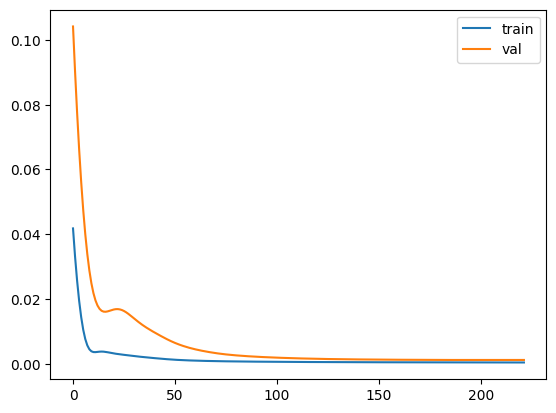

4/4 [==============================] - 0s 3ms/step
train mae: 0.753732099895106
val mae: 0.5104658660742188
train smape: 4.706158398604635
val smape: 2.9355845763214834
train forecast bias: 3.463404568024766
val forecast bias: 2.6434866109263426


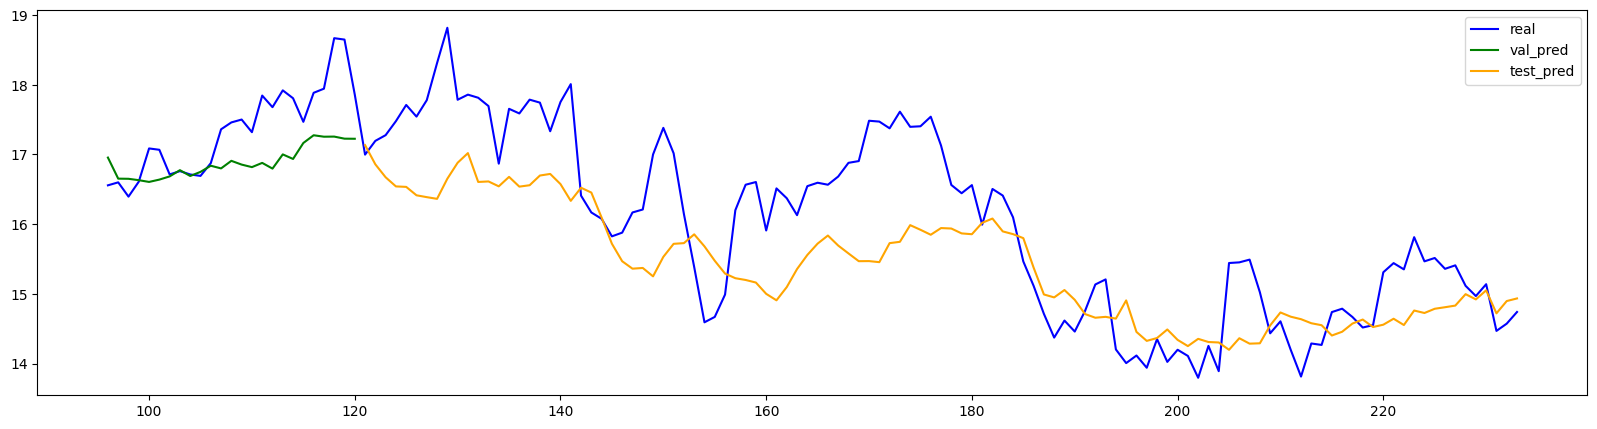

Epoch 1/1000
6/6 [==============================] - 1s 63ms/step - loss: 0.0670 - val_loss: 0.0312
Epoch 2/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0390 - val_loss: 0.0140
Epoch 3/1000
6/6 [==============================] - 0s 36ms/step - loss: 0.0200 - val_loss: 0.0045
Epoch 4/1000
6/6 [==============================] - 0s 34ms/step - loss: 0.0092 - val_loss: 0.0011
Epoch 5/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0046 - val_loss: 0.0016
Epoch 6/1000
6/6 [==============================] - 0s 47ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 7/1000
6/6 [==============================] - 0s 41ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 8/1000
6/6 [==============================] - 0s 37ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 9/1000
6/6 [==============================] - 0s 40ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 10/1000
6/6 [==============================] - 0s 35ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 11/

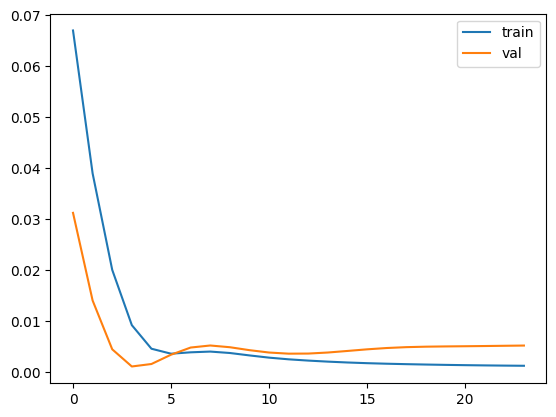

4/4 [==============================] - 0s 4ms/step
train mae: 1.683195633743151
val mae: 1.271663189795961
train smape: 11.847250140520686
val smape: 8.340437380042715
train forecast bias: -10.366094199316732
val forecast bias: -7.960295472130751


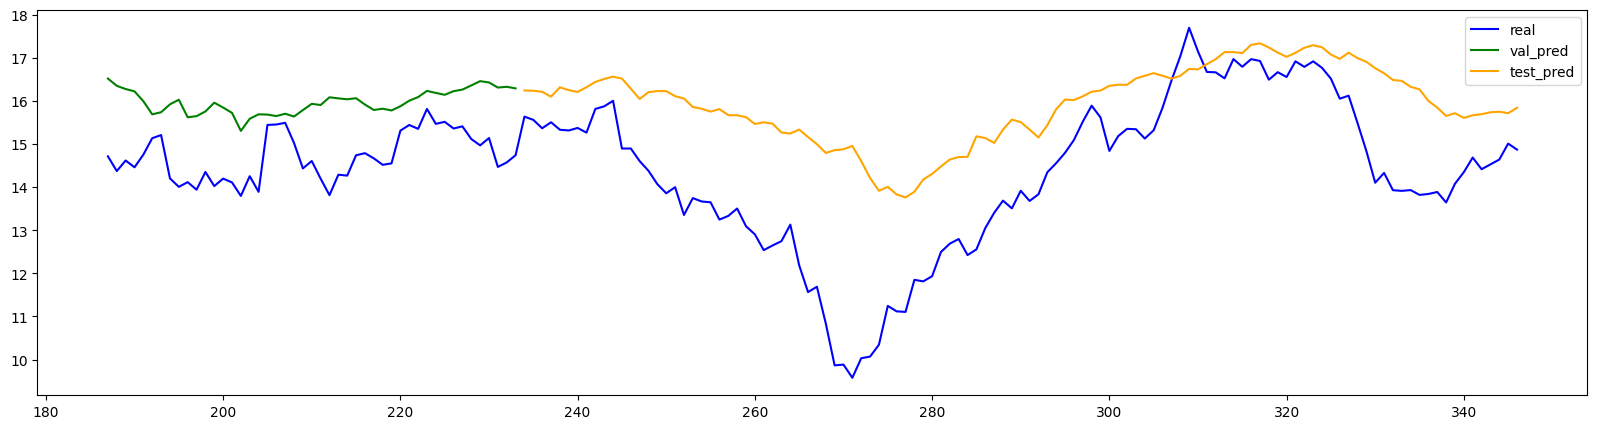

Epoch 1/1000
9/9 [==============================] - 2s 50ms/step - loss: 0.1340 - val_loss: 0.0990
Epoch 2/1000
9/9 [==============================] - 0s 38ms/step - loss: 0.0767 - val_loss: 0.0547
Epoch 3/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0395 - val_loss: 0.0271
Epoch 4/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0182 - val_loss: 0.0125
Epoch 5/1000
9/9 [==============================] - 0s 42ms/step - loss: 0.0081 - val_loss: 0.0062
Epoch 6/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/1000
9/9 [==============================] - 0s 33ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 8/1000
9/9 [==============================] - 0s 32ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/1000
9/9 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 0.0040
Epoch 10/1000
9/9 [==============================] - 0s 32ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 11/

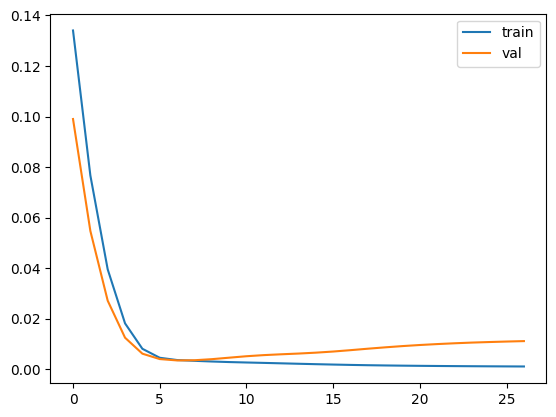

4/4 [==============================] - 0s 4ms/step
train mae: 2.0545517927861847
val mae: 1.8696454884512768
train smape: 15.495650835072805
val smape: 13.164186594096783
train forecast bias: 16.976514003135126
val forecast bias: 14.37287010468438


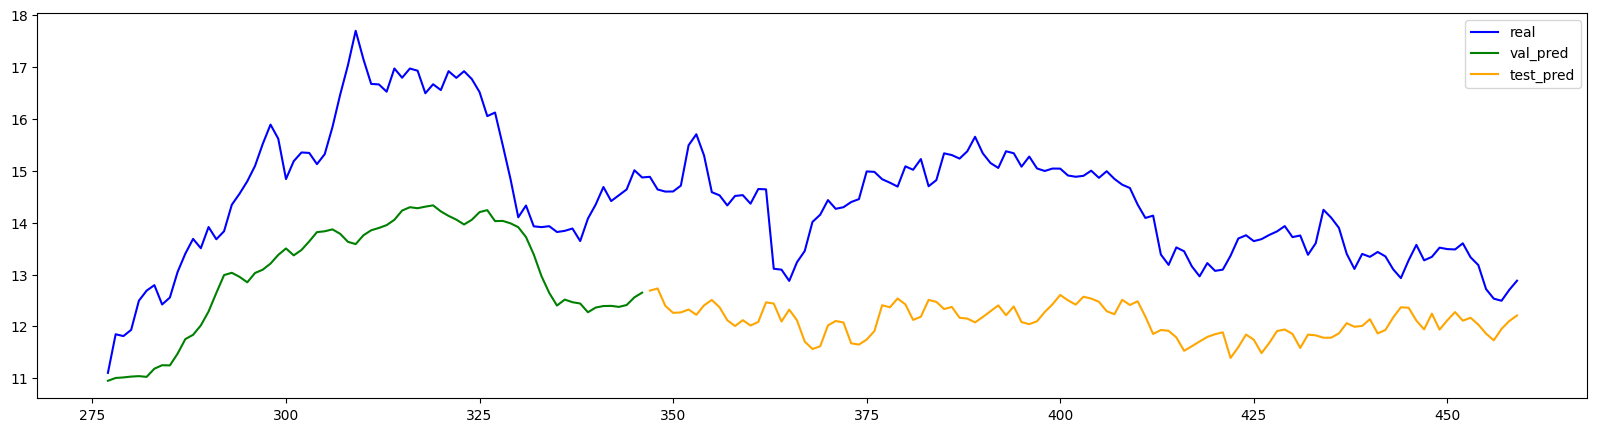

Epoch 1/1000
12/12 [==============================] - 2s 69ms/step - loss: 0.1459 - val_loss: 0.1012
Epoch 2/1000
12/12 [==============================] - 0s 33ms/step - loss: 0.0794 - val_loss: 0.0536
Epoch 3/1000
12/12 [==============================] - 0s 35ms/step - loss: 0.0380 - val_loss: 0.0245
Epoch 4/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0157 - val_loss: 0.0095
Epoch 5/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0065 - val_loss: 0.0036
Epoch 6/1000
12/12 [==============================] - 0s 31ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 7/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 8/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 9/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/1000
12/12 [==============================] - 0s 32ms/step - loss: 0.0032 - val_lo

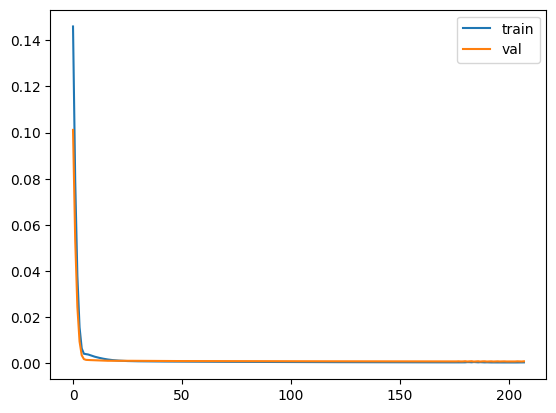

4/4 [==============================] - 0s 4ms/step
train mae: 0.9457899165600804
val mae: 0.4710418618283479
train smape: 5.732886970805983
val smape: 3.333725904848004
train forecast bias: 5.759760257762178
val forecast bias: 1.787992074005661


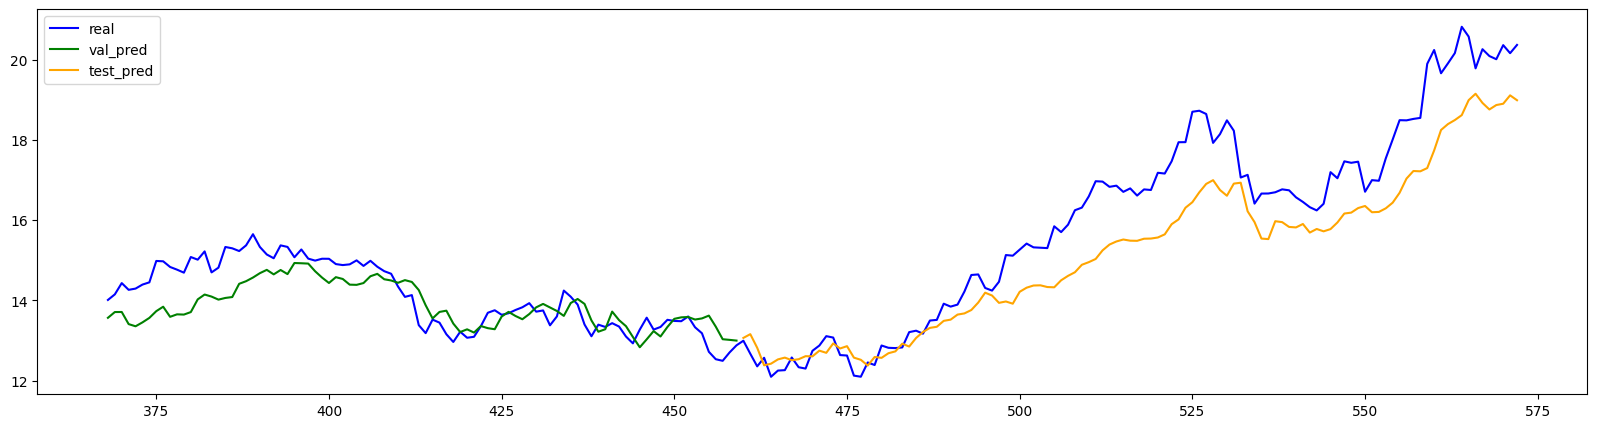

Epoch 1/1000
15/15 [==============================] - 2s 41ms/step - loss: 0.0656 - val_loss: 0.0314
Epoch 2/1000
15/15 [==============================] - 1s 34ms/step - loss: 0.0251 - val_loss: 0.0131
Epoch 3/1000
15/15 [==============================] - 1s 37ms/step - loss: 0.0124 - val_loss: 0.0122
Epoch 4/1000
15/15 [==============================] - 1s 33ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 5/1000
15/15 [==============================] - 0s 33ms/step - loss: 0.0066 - val_loss: 0.0098
Epoch 6/1000
15/15 [==============================] - 0s 33ms/step - loss: 0.0056 - val_loss: 0.0099
Epoch 7/1000
15/15 [==============================] - 0s 31ms/step - loss: 0.0050 - val_loss: 0.0101
Epoch 8/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0044 - val_loss: 0.0102
Epoch 9/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0040 - val_loss: 0.0105
Epoch 10/1000
15/15 [==============================] - 0s 32ms/step - loss: 0.0036 - val_lo

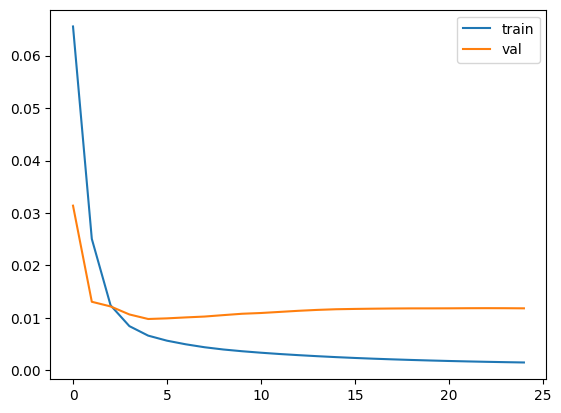

4/4 [==============================] - 0s 4ms/step
train mae: 3.9788686062681484
val mae: 1.8043382667751149
train smape: 18.931094286141604
val smape: 11.4259190608002
train forecast bias: 21.0975772191237
val forecast bias: 12.419864100431468


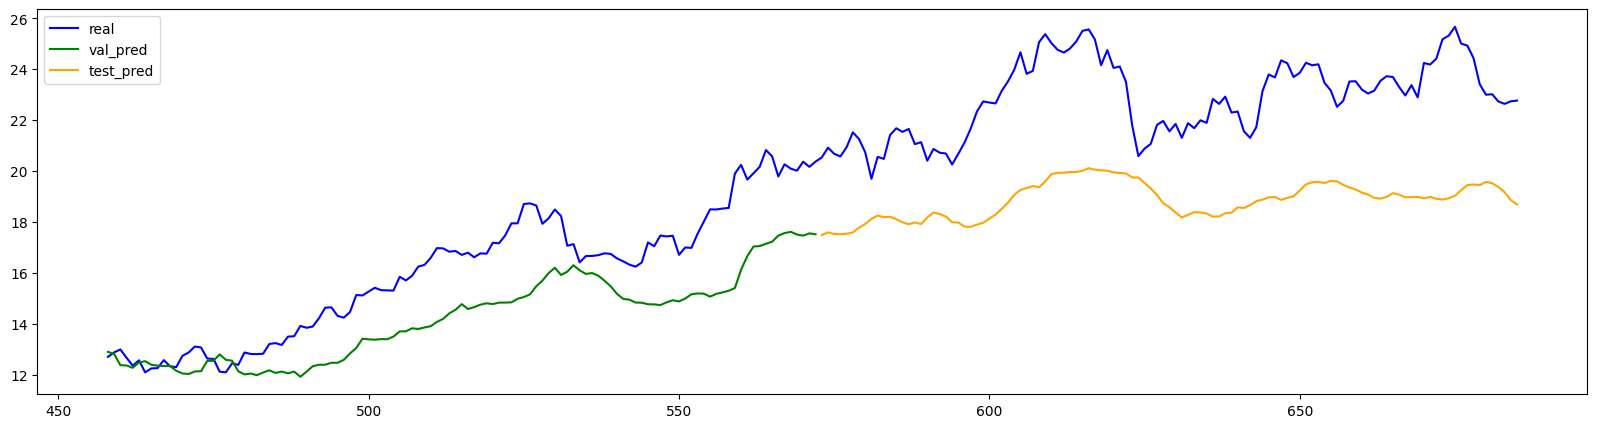

Epoch 1/1000
18/18 [==============================] - 2s 39ms/step - loss: 0.0594 - val_loss: 0.1638
Epoch 2/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0139 - val_loss: 0.0637
Epoch 3/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0074 - val_loss: 0.0493
Epoch 4/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0056 - val_loss: 0.0568
Epoch 5/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0049 - val_loss: 0.0577
Epoch 6/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0043 - val_loss: 0.0530
Epoch 7/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0038 - val_loss: 0.0487
Epoch 8/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 0.0448
Epoch 9/1000
18/18 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0403
Epoch 10/1000
18/18 [==============================] - 1s 31ms/step - loss: 0.0027 - val_lo

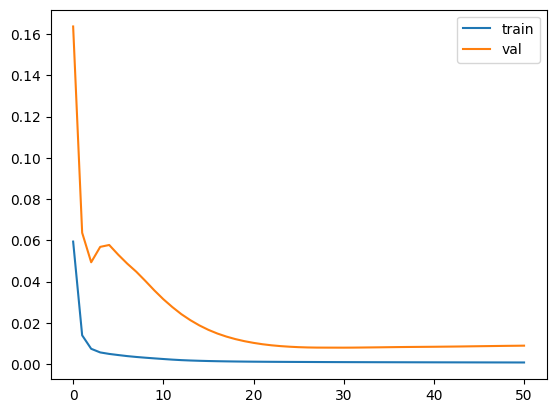

4/4 [==============================] - 0s 4ms/step
train mae: 0.9419908357787004
val mae: 1.544468145136294
train smape: 4.281957598914671
val smape: 6.989807758478282
train forecast bias: 4.0067466370631575
val forecast bias: 7.046115768994521


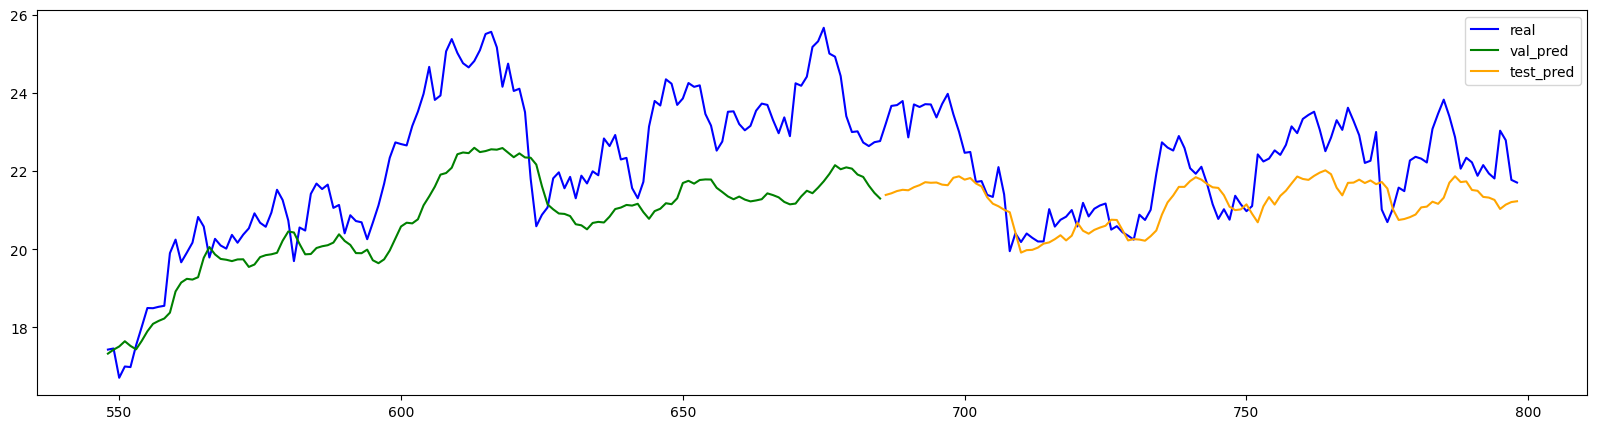

Epoch 1/1000
20/20 [==============================] - 2s 38ms/step - loss: 0.0684 - val_loss: 0.1944
Epoch 2/1000
20/20 [==============================] - 1s 33ms/step - loss: 0.0124 - val_loss: 0.0678
Epoch 3/1000
20/20 [==============================] - 1s 34ms/step - loss: 0.0092 - val_loss: 0.0405
Epoch 4/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0085 - val_loss: 0.0363
Epoch 5/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0068 - val_loss: 0.0297
Epoch 6/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0054 - val_loss: 0.0216
Epoch 7/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0044 - val_loss: 0.0154
Epoch 8/1000
20/20 [==============================] - 1s 32ms/step - loss: 0.0035 - val_loss: 0.0107
Epoch 9/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 10/1000
20/20 [==============================] - 1s 31ms/step - loss: 0.0024 - val_lo

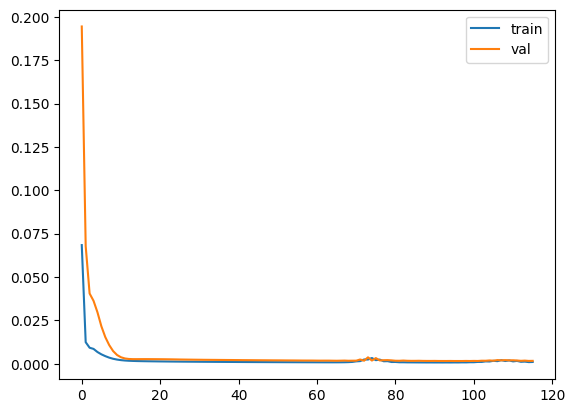

4/4 [==============================] - 0s 3ms/step
train mae: 0.7933491585963427
val mae: 0.6201176273376463
train smape: 3.8115450986093204
val smape: 2.754133935039347
train forecast bias: 0.07533795071120175
val forecast bias: 1.0921309823241647


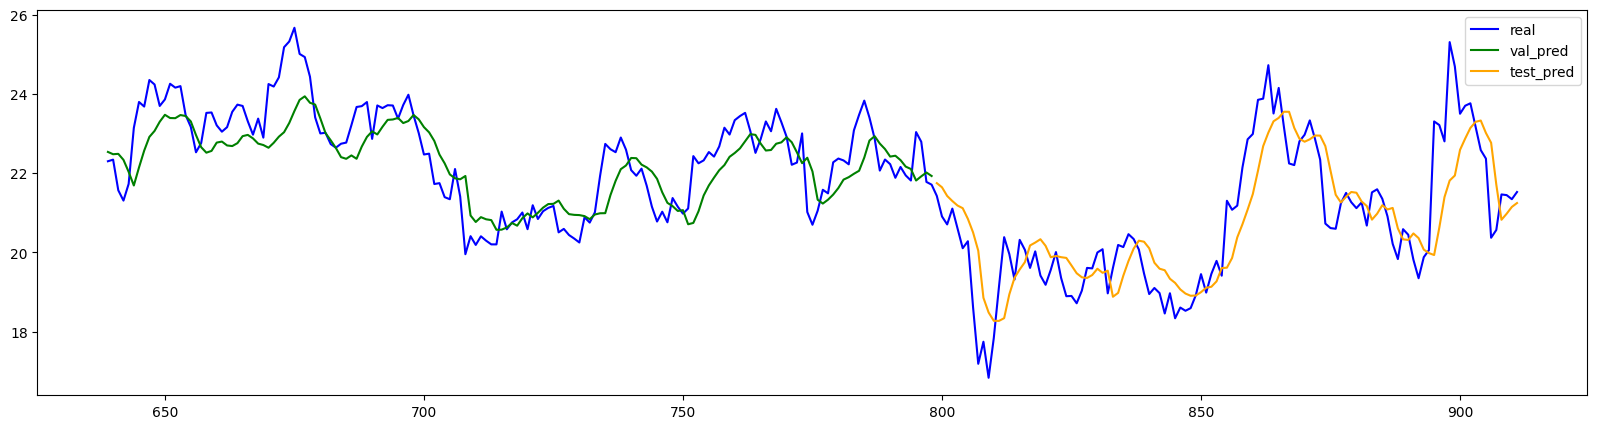

Epoch 1/1000
23/23 [==============================] - 2s 59ms/step - loss: 0.1441 - val_loss: 0.2160
Epoch 2/1000
23/23 [==============================] - 1s 35ms/step - loss: 0.0347 - val_loss: 0.0594
Epoch 3/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0097 - val_loss: 0.0169
Epoch 4/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0077 - val_loss: 0.0092
Epoch 5/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 6/1000
23/23 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 7/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 8/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 9/1000
23/23 [==============================] - 1s 33ms/step - loss: 0.0024 - val_loss: 0.0047
Epoch 10/1000
23/23 [==============================] - 1s 32ms/step - loss: 0.0022 - val_lo

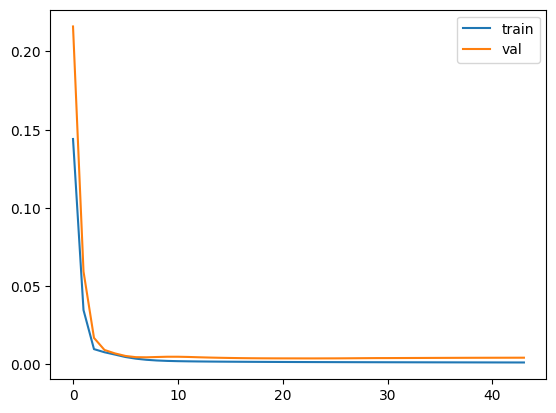

4/4 [==============================] - 0s 6ms/step
train mae: 1.0923741540548948
val mae: 0.9436422194857571
train smape: 5.2582472133553475
val smape: 4.473276743075351
train forecast bias: 0.47607029209676716
val forecast bias: 2.804754188838533


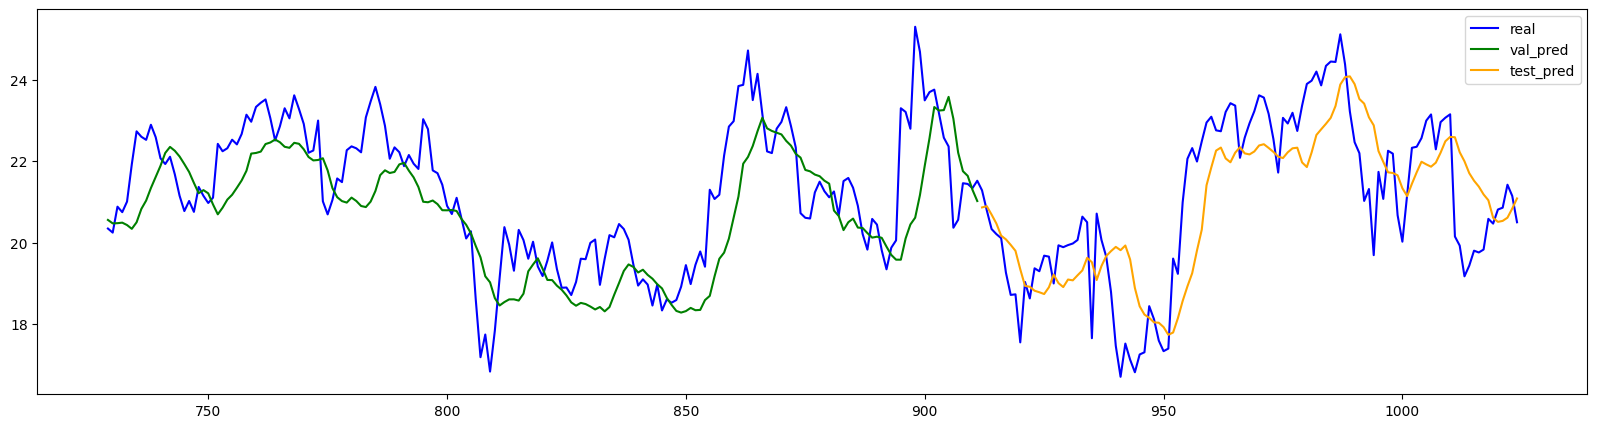

Epoch 1/1000
26/26 [==============================] - 2s 44ms/step - loss: 0.0586 - val_loss: 0.0078
Epoch 2/1000
26/26 [==============================] - 1s 38ms/step - loss: 0.0067 - val_loss: 0.0273
Epoch 3/1000
26/26 [==============================] - 1s 37ms/step - loss: 0.0056 - val_loss: 0.0204
Epoch 4/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.0048 - val_loss: 0.0161
Epoch 5/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.0041 - val_loss: 0.0147
Epoch 6/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0036 - val_loss: 0.0120
Epoch 7/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.0031 - val_loss: 0.0093
Epoch 8/1000
26/26 [==============================] - 1s 35ms/step - loss: 0.0027 - val_loss: 0.0073
Epoch 9/1000
26/26 [==============================] - 1s 34ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 10/1000
26/26 [==============================] - 1s 36ms/step - loss: 0.0021 - val_lo

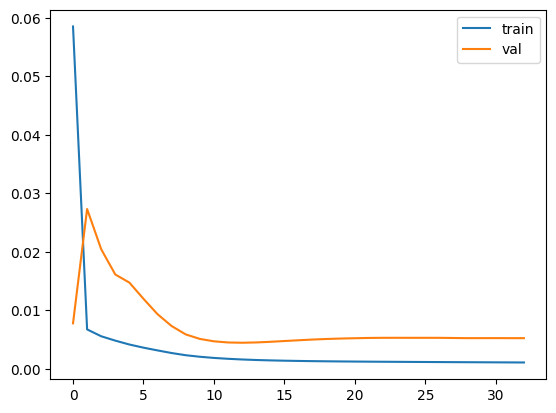

4/4 [==============================] - 0s 4ms/step
train mae: 0.9011122131542105
val mae: 1.1228772098418445
train smape: 5.647651626690631
val smape: 5.3389403165753215
train forecast bias: -4.2334468824085665
val forecast bias: 3.610568579209637


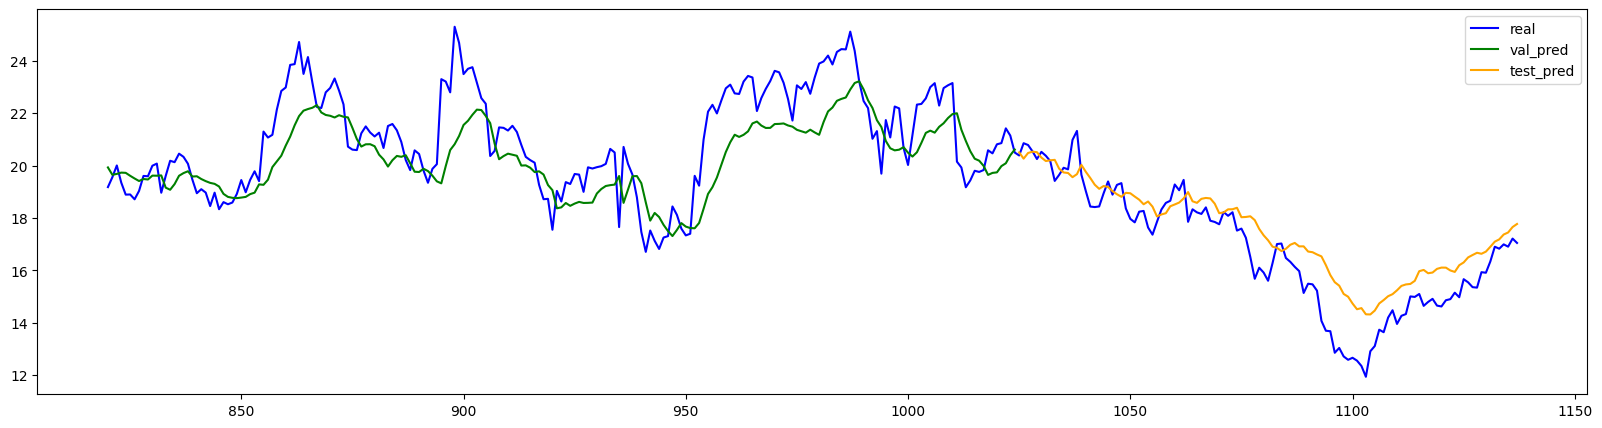

Epoch 1/1000
29/29 [==============================] - 2s 39ms/step - loss: 0.1437 - val_loss: 0.0774
Epoch 2/1000
29/29 [==============================] - 1s 35ms/step - loss: 0.0231 - val_loss: 0.0142
Epoch 3/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0166 - val_loss: 0.0223
Epoch 4/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0133 - val_loss: 0.0232
Epoch 5/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0094 - val_loss: 0.0235
Epoch 6/1000
29/29 [==============================] - 1s 34ms/step - loss: 0.0068 - val_loss: 0.0225
Epoch 7/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0052 - val_loss: 0.0201
Epoch 8/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0041 - val_loss: 0.0176
Epoch 9/1000
29/29 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 0.0149
Epoch 10/1000
29/29 [==============================] - 1s 32ms/step - loss: 0.0029 - val_lo

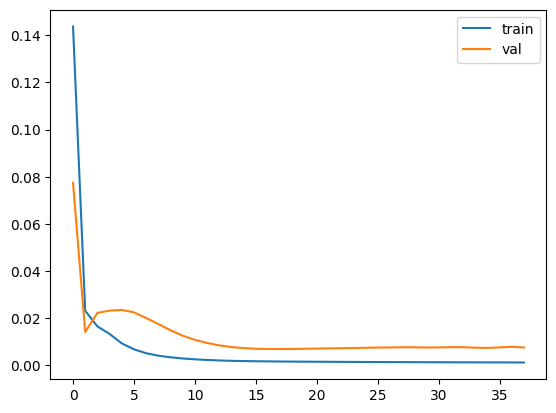

4/4 [==============================] - 0s 6ms/step
train mae: 1.2938662369379363
val mae: 1.354997687771446
train smape: 6.860041483593718
val smape: 7.570453809026207
train forecast bias: -0.5099516056110102
val forecast bias: -4.981451607776589


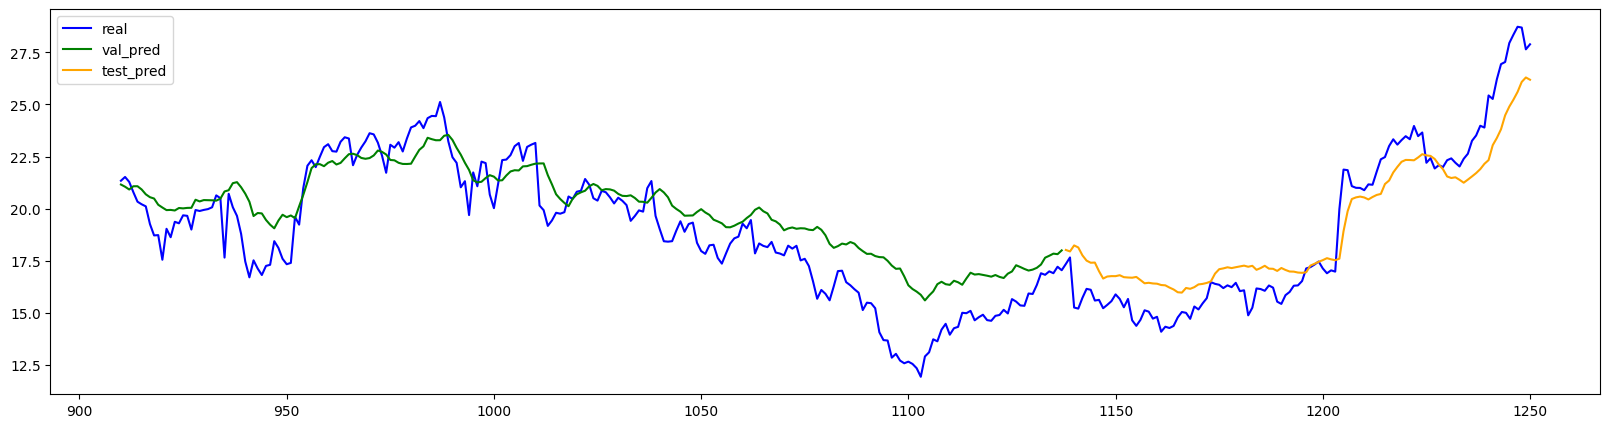

In [44]:
tscv = TimeSeriesSplit(n_splits=10)
t_maes=[]
v_maes=[]
t_smapes=[]
v_smapes=[]

t_forecast_biases=[]
v_forecast_biases=[]
for train_index, test_index in tscv.split(X):
    X_tmp, X_test = X[train_index], X[test_index]
    y_tmp, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.8)  # Adjust the validation split percentage as needed
    X_train, x_val = X_tmp[:val_split], X_tmp[val_split:]
    y_train, y_val = y_tmp[:val_split], y_tmp[val_split:]

    model=model = tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 
    y_val=np.repeat(y_val,X.shape[2],axis=1)
    y_val=scaler.inverse_transform(y_val)[:,-1]

    y_val_pred=model.predict(x_val)
    val_pred=np.repeat(y_val_pred,X.shape[2],axis=1)
    val_pred=scaler.inverse_transform(val_pred)[:,-1]

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    v_time=range(X_train.shape[0],X_train.shape[0]+len(y_val))

    t_time=range(X_train.shape[0]+len(y_val),X_train.shape[0]+len(y_val)+len(y_test))

    r_time=range(X_train.shape[0],X_train.shape[0]+len(y_val)+len(y_test))

    t_mae=mae(pred,y_test)
    t_maes.append(t_mae)
    print('train mae:',t_mae)
    v_mae=mae(val_pred,y_val)
    v_maes.append(v_mae)
    print('val mae:',v_mae)
    t_smape=smape(pred,y_test)
    t_smapes.append(t_smape)
    print('train smape:',t_smape)
    v_smape=smape(val_pred,y_val)
    v_smapes.append(v_smape)
    print('val smape:',v_smape)

    t_forecast_bias=forecast_bias(pred,y_test)
    t_forecast_biases.append(t_forecast_bias)
    print('train forecast bias:',t_forecast_bias)
    v_forecast_bias=forecast_bias(val_pred,y_val)
    v_forecast_biases.append(v_forecast_bias)
    print('val forecast bias:',v_forecast_bias)
    

    #plotting the results
    real=np.concatenate((y_val,y_test))
    plt.figure(figsize=(20,5))
    plt.plot(r_time,real,label='real',color='blue')
    plt.plot(v_time,val_pred,label='val_pred',color='green')
    plt.plot(t_time,pred, label='test_pred',color='orange') 
    plt.legend()
    plt.show()

In [45]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 288)               140832    
 onal)                                                           
                                                                 
 dense_9 (Dense)             (None, 1)                 289       
                                                                 
Total params: 141121 (551.25 KB)
Trainable params: 141121 (551.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
Taverage_mae=np.mean(t_maes)

print('Average MAE in testing:',Taverage_mae)

Vaverage_mae=np.mean(v_maes)

print('Average MAE in validation:',Vaverage_mae)

Taverage_smape=np.mean(t_smapes)

print('Average SMAPE in testing:',Taverage_smape)

Vaverage_smape=np.mean(v_smapes)

print('Average SMAPE in validation:',Vaverage_smape)


Taverage_forecast_bias=np.mean(t_forecast_biases)

print('Average forecast bias in testing:',Taverage_forecast_bias)

Vaverage_forecast_bias=np.mean(v_forecast_biases)

print('Average forecast bias in validation:',Vaverage_forecast_bias)

Average MAE in testing: 1.4438830647774754
Average MAE in validation: 1.1513257562497907
Average SMAPE in testing: 8.25724836523094
Average SMAPE in validation: 6.6326466078303685
Average forecast bias in testing: 3.6745918240580595
Average forecast bias in validation: 3.2836035329507363
